In [9]:
import pydicom as pdc
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from tensorflow.keras import layers
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
# Load Dataset
path = '../Code/benchmark_liver_tumor/raw/np/'
X_p_tr, X_m_tr, X_i_tr, Y_tr = np.load(path+'X_p_tr.npy'), np.load(path+'X_m_tr.npy', allow_pickle=True), np.load(path+'X_i_tr.npy'), np.load(path+'Y_tr.npy')
X_p_te, X_m_te, X_i_te, Y_te = np.load(path+'X_p_te.npy'), np.load(path+'X_m_te.npy', allow_pickle=True), np.load(path+'X_i_te.npy'), np.load(path+'Y_te.npy')
X_m_tr, X_m_te = X_m_tr.astype('float32'), X_m_te.astype('float32')
Y_tr_cat, Y_te_cat = to_categorical(Y_tr), to_categorical(Y_te) # one-hot-encode
print(X_p_tr.shape, X_m_tr.shape, X_i_tr.shape, Y_tr.shape, Y_tr_cat.shape)
print(X_p_te.shape, X_m_te.shape, X_i_te.shape, Y_te.shape, Y_te_cat.shape)

(10977,) (10977, 3) (10977, 5, 32, 32) (10977,) (10977, 3)
(2430,) (2430, 3) (2430, 5, 32, 32) (2430,) (2430, 3)


In [11]:
# Permute Channels
X_i_tr = np.rollaxis(X_i_tr, 1, 4)
X_i_te = np.rollaxis(X_i_te, 1, 4)
print(X_i_tr.shape)
print(X_i_te.shape)

(10977, 32, 32, 5)
(2430, 32, 32, 5)


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 5)]  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 32, 5, 1) 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 32, 32, 5, 16 144         reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_4 (MaxPooling3D)  (None, 16, 16, 2, 16 0           conv3d_4[0][0]                   
_______________________________________________________________________________________

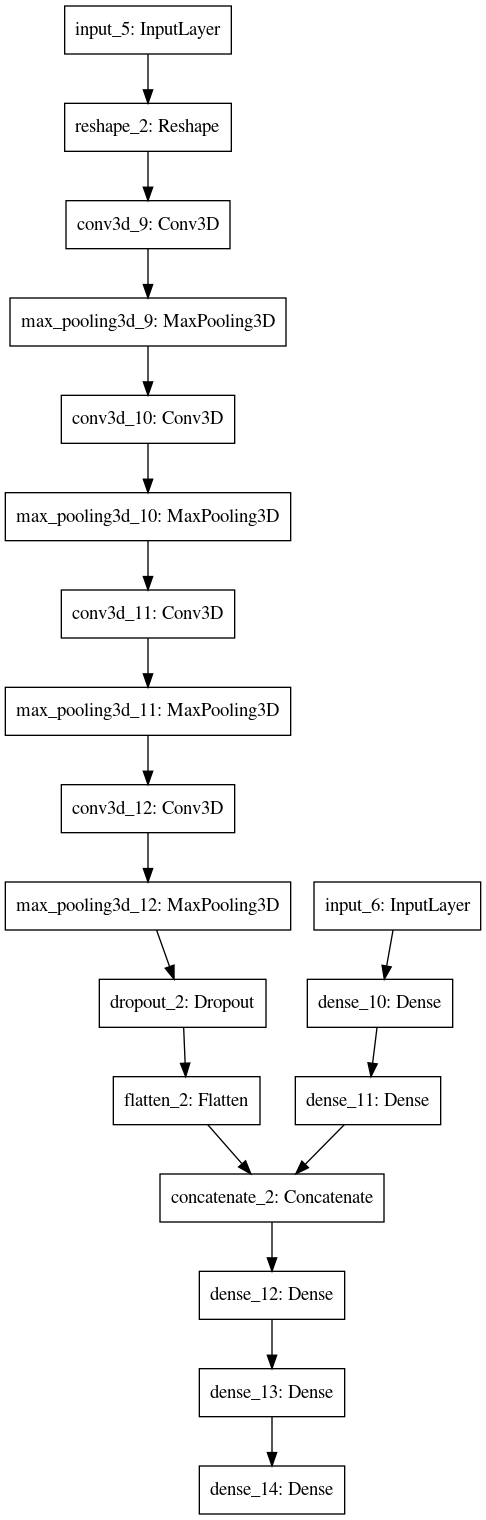

In [12]:
# Build Model (3D-CNN)
cnn_input = tf.keras.Input((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3]))
h = tf.keras.layers.Reshape((X_i_tr.shape[1], X_i_tr.shape[2], X_i_tr.shape[3], 1))(cnn_input)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 2))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 2), padding='same', activation='tanh')(h)
h = tf.keras.layers.MaxPool3D((2, 2, 1))(h)
h = tf.keras.layers.Dropout(0.5)(h)
cnn_output = tf.keras.layers.Flatten()(h)

# Build Model (Meta-data)
dnn_input = tf.keras.Input((X_m_tr.shape[1],))
h = tf.keras.layers.Dense(6, activation='tanh')(dnn_input)
dnn_output = tf.keras.layers.Dense(6, activation='tanh')(h)

# Fusion Model
concat = tf.keras.layers.Concatenate(axis=-1)([cnn_output, dnn_output])
h = tf.keras.layers.Dense(128, activation='tanh')(concat)
h = tf.keras.layers.Dense(64, activation='tanh')(h)
cnn_dnn_output = tf.keras.layers.Dense(Y_tr_cat.shape[1], activation='softmax')(h)
cnn_meta = tf.keras.Model(inputs=[cnn_input, dnn_input], outputs=cnn_dnn_output)
cnn_meta.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_meta.summary()
display(Image(filename="./model/cnn_meta.png"))

In [13]:
# Train Model
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
cnn_meta_history = cnn_meta.fit([X_i_tr, X_m_tr], Y_tr_cat, validation_data=([X_i_te, X_m_te], Y_te_cat), epochs=200, batch_size=512, shuffle=True, verbose=2, callbacks=[es])

Epoch 1/200
22/22 - 68s - loss: 0.8958 - accuracy: 0.6450 - val_loss: 0.9128 - val_accuracy: 0.6259
Epoch 2/200
22/22 - 69s - loss: 0.8504 - accuracy: 0.6659 - val_loss: 0.8419 - val_accuracy: 0.6259
Epoch 3/200
22/22 - 69s - loss: 0.8304 - accuracy: 0.6659 - val_loss: 0.8345 - val_accuracy: 0.6259
Epoch 4/200
22/22 - 68s - loss: 0.8039 - accuracy: 0.6668 - val_loss: 0.8568 - val_accuracy: 0.6255
Epoch 5/200
22/22 - 68s - loss: 0.7531 - accuracy: 0.6904 - val_loss: 0.8831 - val_accuracy: 0.6469
Epoch 6/200
22/22 - 69s - loss: 0.6770 - accuracy: 0.7293 - val_loss: 0.9725 - val_accuracy: 0.5527
Epoch 7/200
22/22 - 68s - loss: 0.5790 - accuracy: 0.7756 - val_loss: 1.1044 - val_accuracy: 0.5938
Epoch 8/200
22/22 - 68s - loss: 0.4743 - accuracy: 0.8203 - val_loss: 1.2835 - val_accuracy: 0.5840
Epoch 9/200
22/22 - 68s - loss: 0.3902 - accuracy: 0.8511 - val_loss: 1.3958 - val_accuracy: 0.5753
Epoch 10/200
22/22 - 68s - loss: 0.3139 - accuracy: 0.8867 - val_loss: 1.6728 - val_accuracy: 0.5543

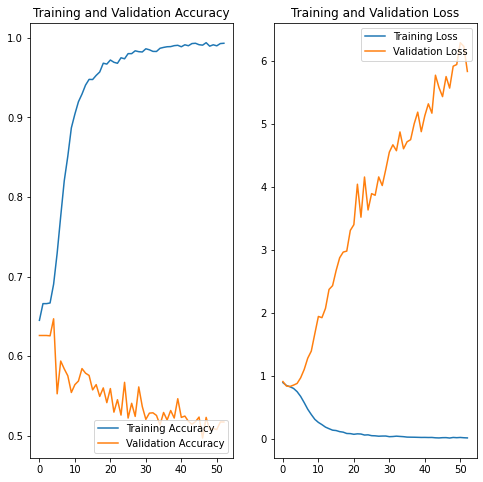

In [15]:
epochs = 53
# Evaluation 
acc = cnn_meta_history.history['accuracy']
val_acc = cnn_meta_history.history['val_accuracy']
loss = cnn_meta_history.history['loss']
val_loss = cnn_meta_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()